# Final Project Step 4 PCA

```
Course:   DS 5001 
Module:   Final
Author:   Thomas McIntyre gem5cm@virginia.edu
Purpose:  This notebook will utlize the data created in step 2 to perform PCA and visualize the components.
```

In [1]:
import pandas as pd
import numpy as np
# from sklearn.decomposition import PCA
from scipy.linalg import norm, eigh
import plotly_express as px
import seaborn as sns; sns.set()
import sys
%matplotlib inline

In [2]:
data_home = "data"
local_lib = "code"
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [3]:
LIB = pd.read_csv(f"{data_home}/LIB.csv").set_index(OHCO[:1])
CORPUS = pd.read_csv(f"{data_home}/CORPUS.csv").set_index(OHCO)
VOCAB = pd.read_csv(f"{data_home}/VOCAB.csv").set_index("term_str")
BOW = pd.read_csv(f"{data_home}/BOW.csv").rename(columns = {"Unnamed: 2": "term_str"}).set_index(["book_id", "chap_num", "term_str"])
TFIDF = pd.read_csv(f"{data_home}/TFIDF.csv").set_index(CHAPS)
DOC = pd.read_csv(f"{data_home}/DOC.csv").set_index(CHAPS)

In [4]:
DOC = DOC.join(LIB, on='book_id')
DOC

doc_str  n_tokens  \
book_id chap_num                                                                
1       1         we should start back gared urged as the woods ...      3860   
        2         the morning had dawned clear and cold with a c...      3037   
        3         catelyn had never liked this godswood she had ...      2074   
        4         her brother held the gown up for her inspectio...      4161   
        5         the visitors poured through the castle gates i...      3801   
...                                                             ...       ...   
26654   13        do you believe in fairies the more quickly thi...      2873   
        14        the pirate ship one green light squinting over...      2337   
        15        hook or me this time odd things happen to all ...      3211   
        16        the return home by two bells that morning they...      2982   
        17        when wendy grew up i hope you want to know wha...      3801   

                                                book_title  \
book_id chap_num                                             
1       1                  A Game of Thrones, by RR Martin   
        2                  A Game of Thrones, by RR Martin   
        3                  A Game of Thrones, by RR Martin   
        4                  A Game of Thrones, by RR Martin   
        5                  A Game of Thrones, by RR Martin   
...                                                    ...   
26654   13        Peter and Wendy, by James Matthew Barrie   
        14        Peter and Wendy, by James Matthew Barrie   
        15        Peter and Wendy, by James Matthew Barrie   
        16        Peter and Wendy, by James Matthew Barrie   
        17        Peter and Wendy, by James Matthew Barrie   

                                                  book_file  \
book_id chap_num                                              
1       1           corpus/MARTIN_A_GAME_OF_THRONES-pg1.txt   
        2           corpus/MARTIN_A_GAME_OF_THRONES-pg1.txt   
        3           corpus/MARTIN_A_GAME_OF_THRONES-pg1.txt   
        4           corpus/MARTIN_A_GAME_OF_THRONES-pg1.txt   
        5           corpus/MARTIN_A_GAME_OF_THRONES-pg1.txt   
...                                                     ...   
26654   13        corpus/BARRIE_PETER_AND_WENDY-pg26654.txt   
        14        corpus/BARRIE_PETER_AND_WENDY-pg26654.txt   
        15        corpus/BARRIE_PETER_AND_WENDY-pg26654.txt   
        16        corpus/BARRIE_PETER_AND_WENDY-pg26654.txt   
        17        corpus/BARRIE_PETER_AND_WENDY-pg26654.txt   

                          chap_regex  book_length  n_chaps             genre  \
book_id chap_num                                                               
1       1         [A-Z]+[A-Z]+[A-Z]+       294315       78           fantasy   
        2         [A-Z]+[A-Z]+[A-Z]+       294315       78           fantasy   
        3         [A-Z]+[A-Z]+[A-Z]+       294315       78           fantasy   
        4         [A-Z]+[A-Z]+[A-Z]+       294315       78           fantasy   
        5         [A-Z]+[A-Z]+[A-Z]+       294315       78           fantasy   
...                              ...          ...      ...               ...   
26654   13         ((CHAPTER)\s+\D+)        48031       17  childrensfantasy   
        14         ((CHAPTER)\s+\D+)        48031       17  childrensfantasy   
        15         ((CHAPTER)\s+\D+)        48031       17  childrensfantasy   
        16         ((CHAPTER)\s+\D+)        48031       17  childrensfantasy   
        17         ((CHAPTER)\s+\D+)        48031       17  childrensfantasy   

                       mood           author  \
book_id chap_num                               
1       1         adventure        RR Martin   
        2         adventure        RR Martin   
        3         adventure        RR Martin   
        4         adventure        RR Martin   
        5         adventure        RR Martin   
..

In [5]:
top2000 = VOCAB.loc[VOCAB["max_pos"].isin(["NN","NNS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "JJ", "JJR", "JJS", "RB", "RBR", "RBS"])].sort_values("dfidf", ascending = False).head(2000)
top2000

n  tfidf_mean   df       dfidf         p          i max_pos  \
term_str                                                                   
easy       264    0.003811  196  282.883248  0.000305  11.676997      JJ   
present    359    0.005527  197  282.880161  0.000415  11.233551      JJ   
fool       388    0.005420  195  282.878975  0.000449  11.121478      NN   
big        489    0.006594  195  282.878975  0.000566  10.787701      JJ   
loved      381    0.005573  195  282.878975  0.000441  11.147744     VBD   
...        ...         ...  ...         ...       ...        ...     ...   
footsteps   72    0.001811   53  176.493777  0.000083  13.551466     NNS   
wretch      80    0.001917   53  176.493777  0.000093  13.399463      NN   
yielded     67    0.001791   53  176.493777  0.000078  13.655302     VBN   
bench       99    0.002380   53  176.493777  0.000115  13.092035      NN   
mocking     59    0.001500   53  176.493777  0.000068  13.838748      NN   

           n_pos  stop  
term_str                
easy        10.0     0  
present      9.0     0  
fool        10.0     0  
big          6.0     0  
loved        9.0     0  
...          ...   ...  
footsteps    5.0     0  
wretch       7.0     0  
yielded      7.0     0  
bench        4.0     0  
mocking      3.0     0  

[2000 rows x 9 columns]

In [6]:
TFIDF = TFIDF[top2000.index]
TFIDF

easy   present      fool       big     loved  darkness  \
book_id chap_num                                                               
1       1         0.000000  0.000000  0.011165  0.011165  0.011165  0.033494   
        2         0.009425  0.000000  0.000000  0.009449  0.009449  0.000000   
        3         0.016520  0.000000  0.000000  0.000000  0.016562  0.016562   
        4         0.006601  0.000000  0.013235  0.033088  0.006618  0.006618   
        5         0.008575  0.000000  0.000000  0.008597  0.034388  0.051581   
...                    ...       ...       ...       ...       ...       ...   
26654   13        0.014295  0.028517  0.000000  0.000000  0.057326  0.028663   
        14        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        15        0.007893  0.000000  0.000000  0.000000  0.000000  0.000000   
        16        0.000000  0.000000  0.000000  0.021334  0.000000  0.000000   
        17        0.006578  0.006561  0.000000  0.013189  0.006595  0.006595   

                     steps      shut       age    living  ...  intended  \
book_id chap_num                                          ...             
1       1         0.000000  0.000000  0.000000  0.022160  ...       0.0   
        2         0.000000  0.000000  0.018755  0.000000  ...       0.0   
        3         0.000000  0.000000  0.032874  0.032874  ...       0.0   
        4         0.000000  0.000000  0.006567  0.000000  ...       0.0   
        5         0.008532  0.000000  0.008532  0.017063  ...       0.0   
...                    ...       ...       ...       ...  ...       ...   
26654   13        0.000000  0.000000  0.000000  0.014223  ...       0.0   
        14        0.000000  0.014083  0.000000  0.000000  ...       0.0   
        15        0.000000  0.000000  0.000000  0.007853  ...       0.0   
        16        0.000000  0.010586  0.000000  0.010586  ...       0.0   
        17        0.000000  0.000000  0.006545  0.000000  ...       0.0   

                   roaring       men     light  gentlemen  footsteps  wretch  \
book_id chap_num                                                               
1       1         0.000000  0.066082  0.051297   0.000000   0.000000     0.0   
        2         0.000000  0.031071  0.000000   0.000000   0.000000     0.0   
        3         0.000000  0.043570  0.021742   0.000000   0.000000     0.0   
        4         0.010818  0.056578  0.017375   0.000000   0.000000     0.0   
        5         0.000000  0.039577  0.011286   0.000000   0.028264     0.0   
...                    ...       ...       ...        ...        ...     ...   
26654   13        0.000000  0.000000  0.047034   0.000000   0.000000     0.0   
        14        0.000000  0.009333  0.018629   0.023328   0.000000     0.0   
        15        0.000000  0.000000  0.005194   0.000000   0.000000     0.0   
        16        0.000000  0.000000  0.000000   0.000000   0.000000     0.0   
        17        0.000000  0.000000  0.025972   0.000000   0.000000     0.0   

                  yielded  bench   mocking  
book_id chap_num                            
1       1             0.0    0.0  0.018353  
        2             0.0    0.0  0.000000  
        3             0.0    0.0  0.000000  
        4             0.0    0.0  0.000000  
        5             0.0    0.0  0.000000  
...                   ...    ...       ...  
26654   13            0.0    0.0  0.000000  
        14            0.0    0.0  0.000000  
        15            0.0    0.0  0.000000  
        16            0.0    0.0  0.000000  
        17            0.0    0.0  0.000000  

[533 rows x 2000 columns]

In [7]:
exec(open("code/methods.py").read())
LOADINGS, DCM, COMPINF = get_pca(TFIDF, k=10, norm_docs=True, center_by_mean=False, center_by_variance=False)

In [8]:
LOADINGS

pc_id             0         1         2         3         4         5  \
term_str                                                                
easy      -0.002884  0.007308  0.006637 -0.002790 -0.010034 -0.005328   
present    0.038323 -0.007629 -0.020272  0.030516 -0.041704 -0.016748   
fool      -0.037409  0.023864 -0.038274  0.001731 -0.018462 -0.009816   
big       -0.046661  0.035626  0.049218 -0.009898  0.017349  0.009410   
loved     -0.008453 -0.016437 -0.033531  0.002029  0.003691 -0.056289   
...             ...       ...       ...       ...       ...       ...   
footsteps -0.003974  0.003658  0.000333 -0.008707 -0.006167  0.001133   
wretch     0.008919 -0.020050 -0.006966 -0.007600 -0.006786  0.010699   
yielded    0.000186  0.003630  0.000756 -0.000111 -0.006991 -0.006691   
bench     -0.006755  0.016277  0.004147 -0.014952 -0.011422  0.010962   
mocking   -0.006068  0.004620 -0.003585  0.006803  0.009306 -0.007563   

pc_id             6         7         8         9  
term_str                                           
easy      -0.000367 -0.014834 -0.024658  0.002429  
present    0.021737 -0.010968 -0.000754 -0.022120  
fool       0.002549  0.016554  0.007637 -0.003222  
big        0.047200 -0.001070 -0.002328  0.027007  
loved      0.004368 -0.003358  0.020206  0.010254  
...             ...       ...       ...       ...  
footsteps  0.000736  0.017392 -0.010996  0.003062  
wretch     0.017039  0.017996  0.001405  0.004022  
yielded    0.015336  0.002343 -0.001420 -0.002982  
bench      0.017917  0.003427  0.004827  0.002624  
mocking   -0.000830 -0.003530  0.000835  0.004024  

[2000 rows x 10 columns]

In [9]:
DCM

pc_id                    0         1         2         3         4         5  \
book_id chap_num                                                               
1       1        -0.274565  0.128409  0.205919  0.031068 -0.204457 -0.063534   
        2        -0.299369  0.092334 -0.045226  0.092463 -0.096451 -0.043168   
        3        -0.229763  0.069198 -0.058106  0.083305 -0.133646 -0.153285   
        4        -0.305262  0.097910 -0.135328  0.131115 -0.146126 -0.036442   
        5        -0.345383  0.066444 -0.255441  0.065961 -0.186128 -0.064179   
...                    ...       ...       ...       ...       ...       ...   
26654   13        0.068367  0.026752  0.147885  0.151276  0.026228 -0.171708   
        14        0.076021 -0.026692  0.030143  0.112838  0.152753  0.026854   
        15        0.032666  0.010361  0.128657  0.108654  0.155867 -0.000479   
        16        0.137982  0.077220 -0.065199  0.200368  0.441117 -0.240444   
        17        0.125263  0.102080 -0.050461  0.121180  0.317724 -0.270200   

pc_id                    6         7         8         9  
book_id chap_num                                          
1       1         0.064545  0.081993 -0.077075  0.164915  
        2         0.211052  0.034234 -0.130971  0.196188  
        3         0.024623 -0.018159 -0.191070  0.127543  
        4        -0.130285  0.157397  0.148445  0.033631  
        5        -0.093645  0.043644 -0.266186  0.090124  
...                    ...       ...       ...       ...  
26654   13        0.026067  0.188403 -0.079361  0.105727  
        14       -0.045133  0.137186 -0.134518  0.200966  
        15        0.007253  0.281563 -0.148000  0.174539  
        16        0.038112  0.048022 -0.069760  0.155975  
        17        0.022683  0.093753 -0.079742  0.192821  

[533 rows x 10 columns]

In [10]:
COMPINF

pos                                neg  \
pc_id                                                                          
0         sir gentleman dear replied room      king men sword brother knight   
1               lady boy girl door castle          heaven chief god war vain   
2              trees wall tree water road         king lady father queen son   
3            ship house sea home answered     gentleman boy replied dear sir   
4      darling boys cried children mother          sir road master dark door   
5             gentleman men ship dear boy      darling love lady oh children   
6              father wall hes master hed  dragons king dragon sir gentleman   
7            lady girl replied cried door        sir wall darling ice sister   
8           dragons dragon sir blood city       king boy gentleman north son   
9       sir gentleman replied lady mother  sister pocket kitchen queen forge   

        eig_val   exp_var  
pc_id                      
0      0.050579  0.291869  
1      0.026610  0.153558  
2      0.018965  0.109442  
3      0.014813  0.085481  
4      0.013624  0.078617  
5      0.011982  0.069142  
6      0.010402  0.060023  
7      0.009026  0.052084  
8      0.008709  0.050257  
9      0.008582  0.049525

<AxesSubplot:xlabel='pc_id'>

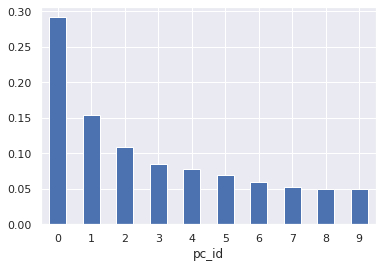

In [11]:
COMPINF.exp_var.plot.bar(rot=0)

In [12]:
try:
    DOC = DOC.join(DCM)
except:
    pass

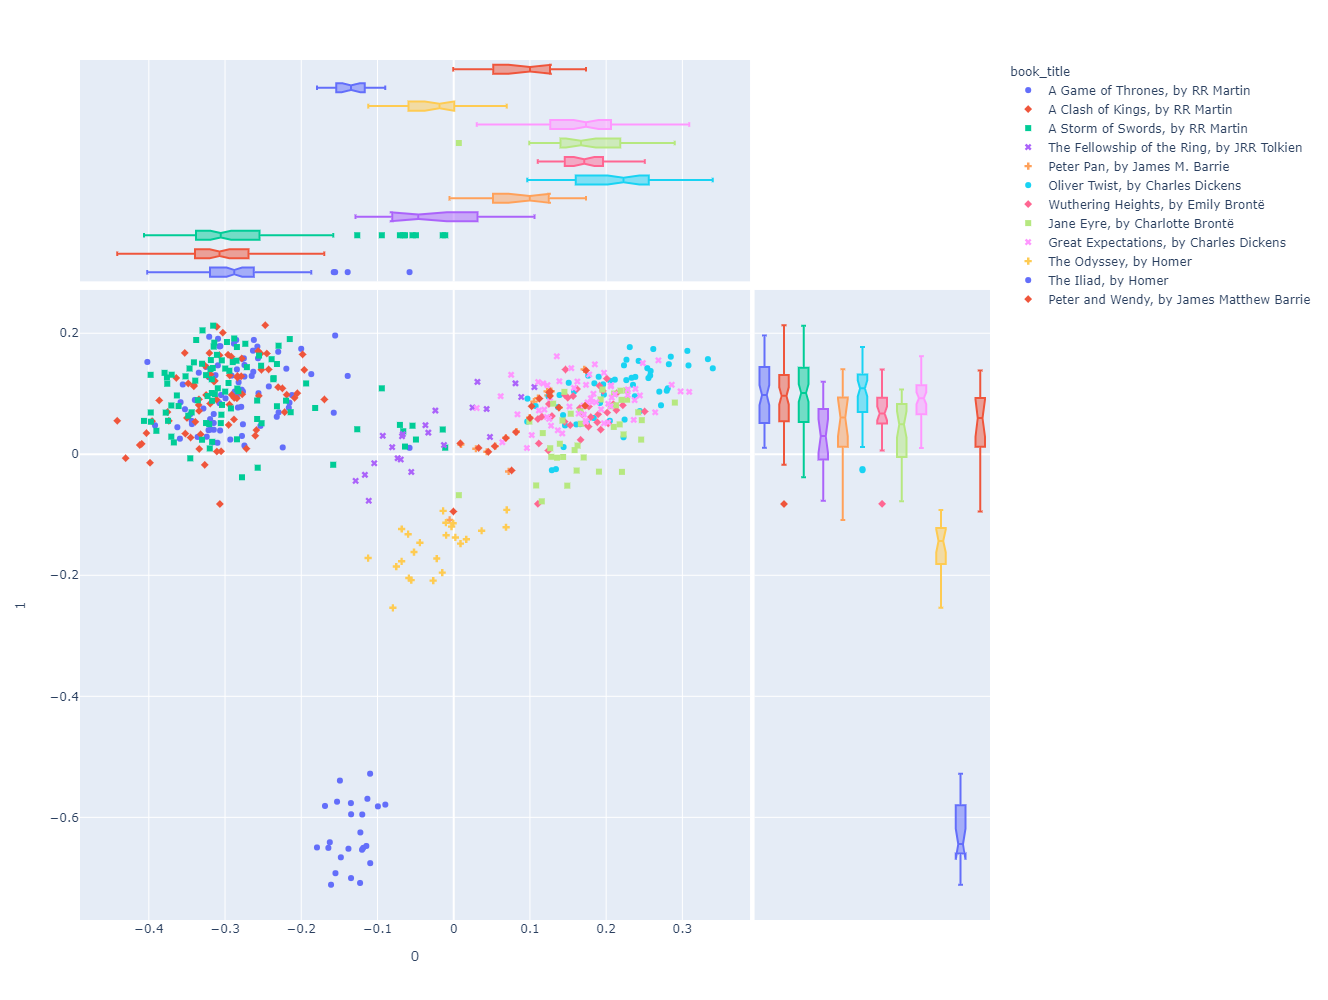

In [13]:
px.scatter(DOC, 0, 1, 
           color='book_title', symbol='book_title', 
           hover_name='book_title', 
           marginal_x='box', marginal_y='box', 
           height=1000)

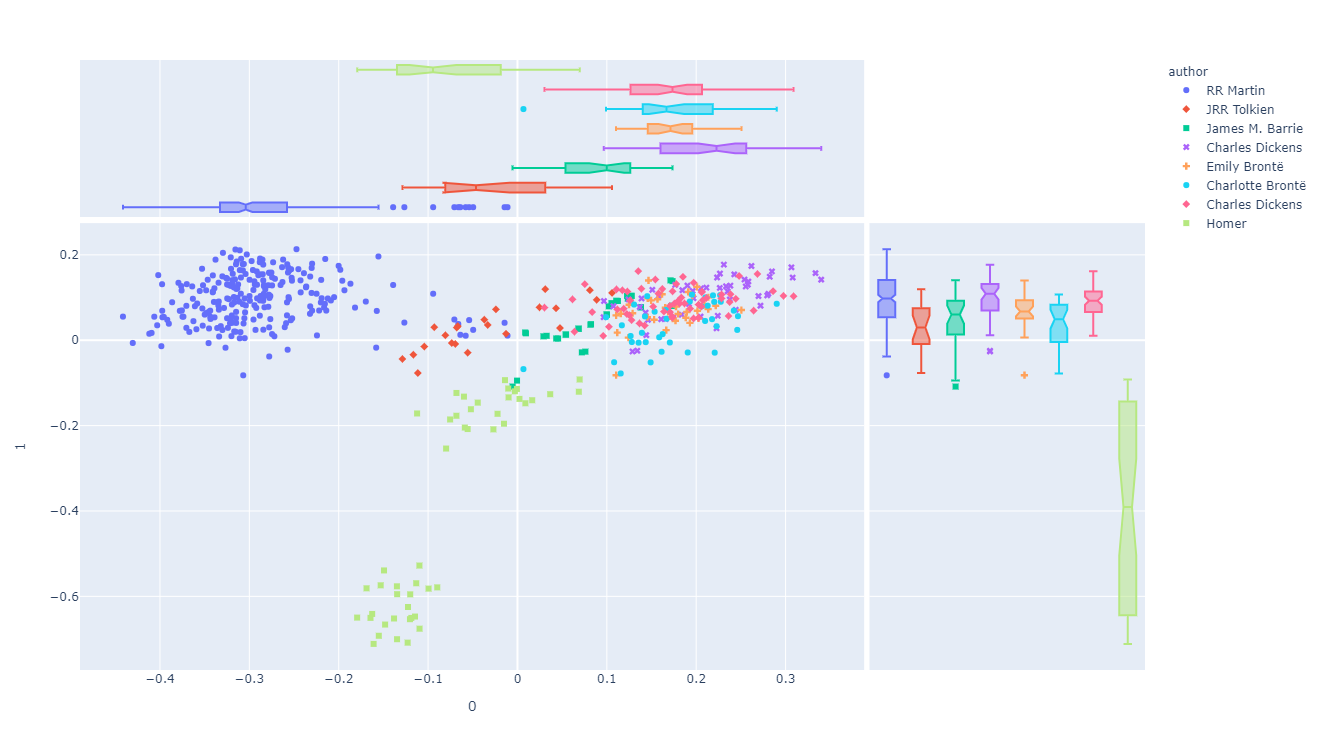

In [18]:
px.scatter(DOC, 0, 1, 
           color='author', symbol='author', 
           hover_name='author', 
           marginal_x='box', marginal_y='box', 
           height=750, width = 1000)

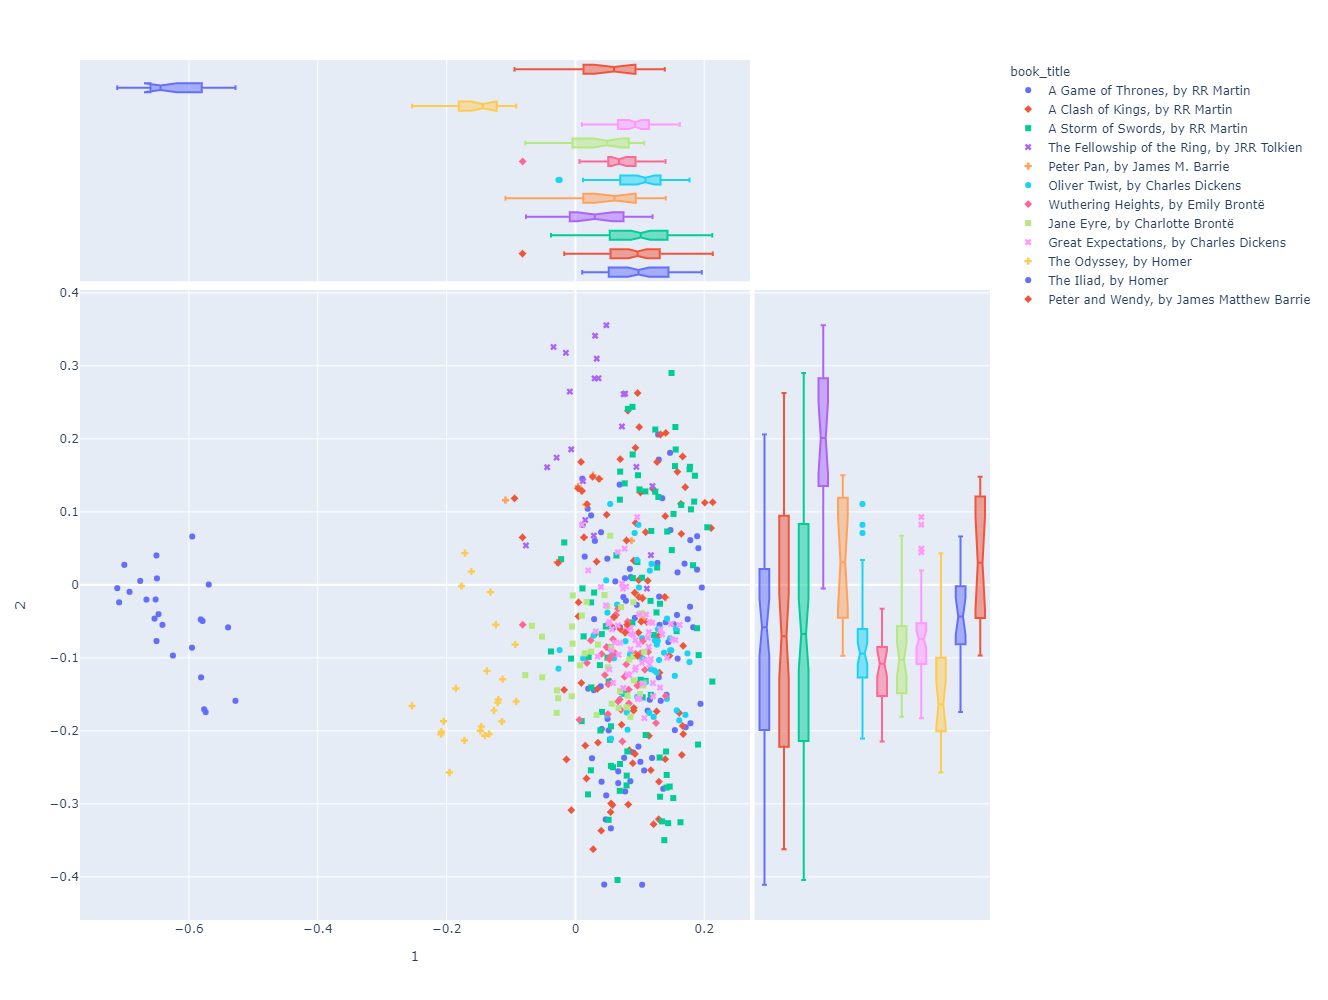

In [34]:
px.scatter(DOC, 1, 2, 
           color='book_title', symbol='book_title', 
           hover_name='book_title', 
           marginal_x='box', marginal_y='box', 
           height=1000)

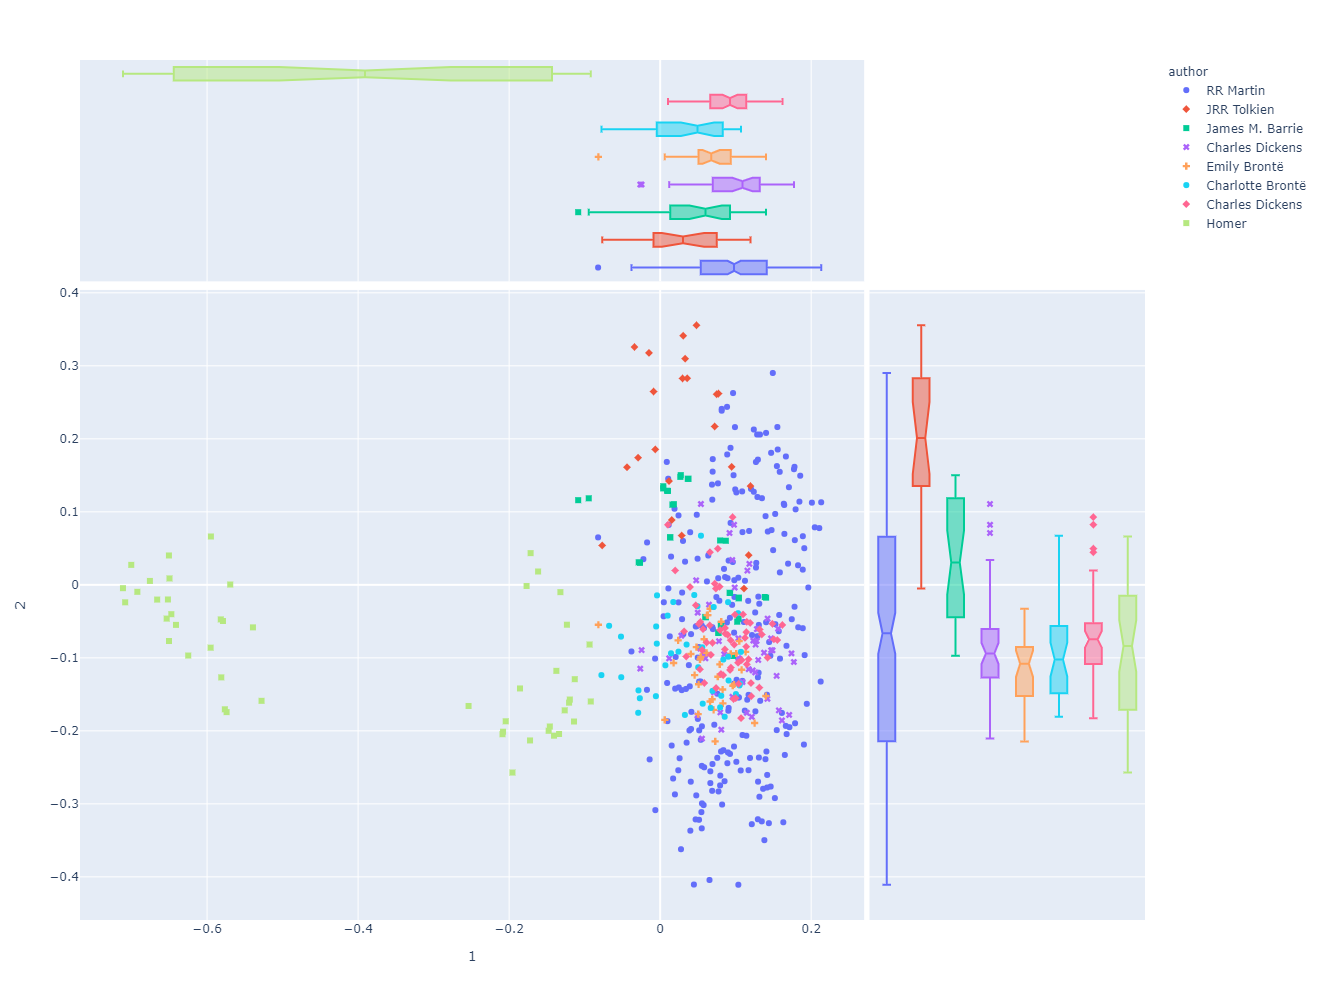

In [35]:
px.scatter(DOC, 1, 2, 
           color='author', symbol='author', 
           hover_name='author', 
           marginal_x='box', marginal_y='box', 
           height=1000)

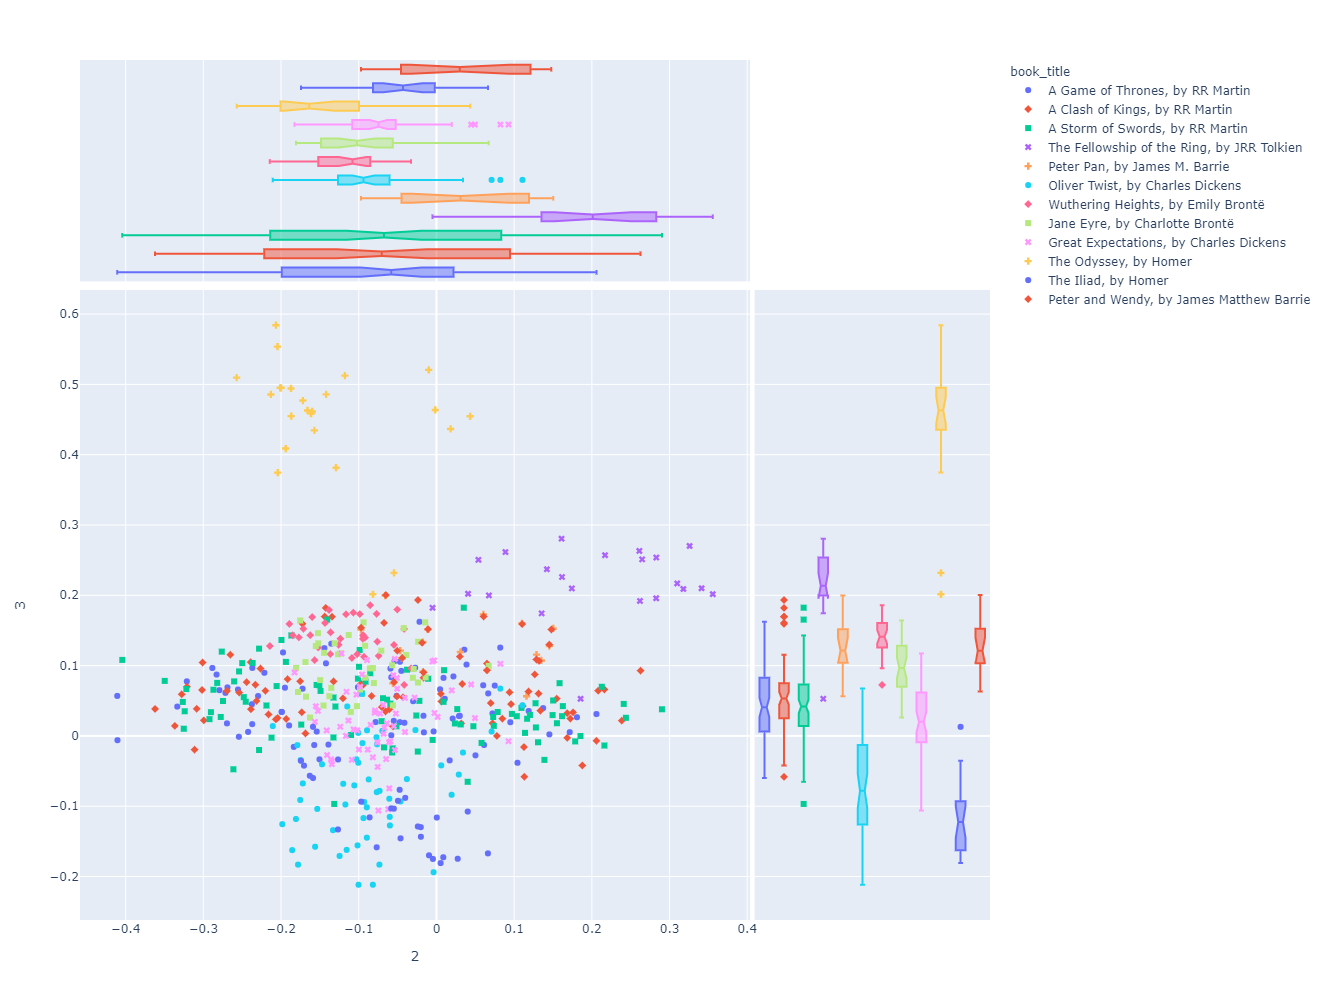

In [36]:
px.scatter(DOC, 2, 3, 
           color='book_title', symbol='book_title', 
           hover_name='book_title', 
           marginal_x='box', marginal_y='box', 
           height=1000)

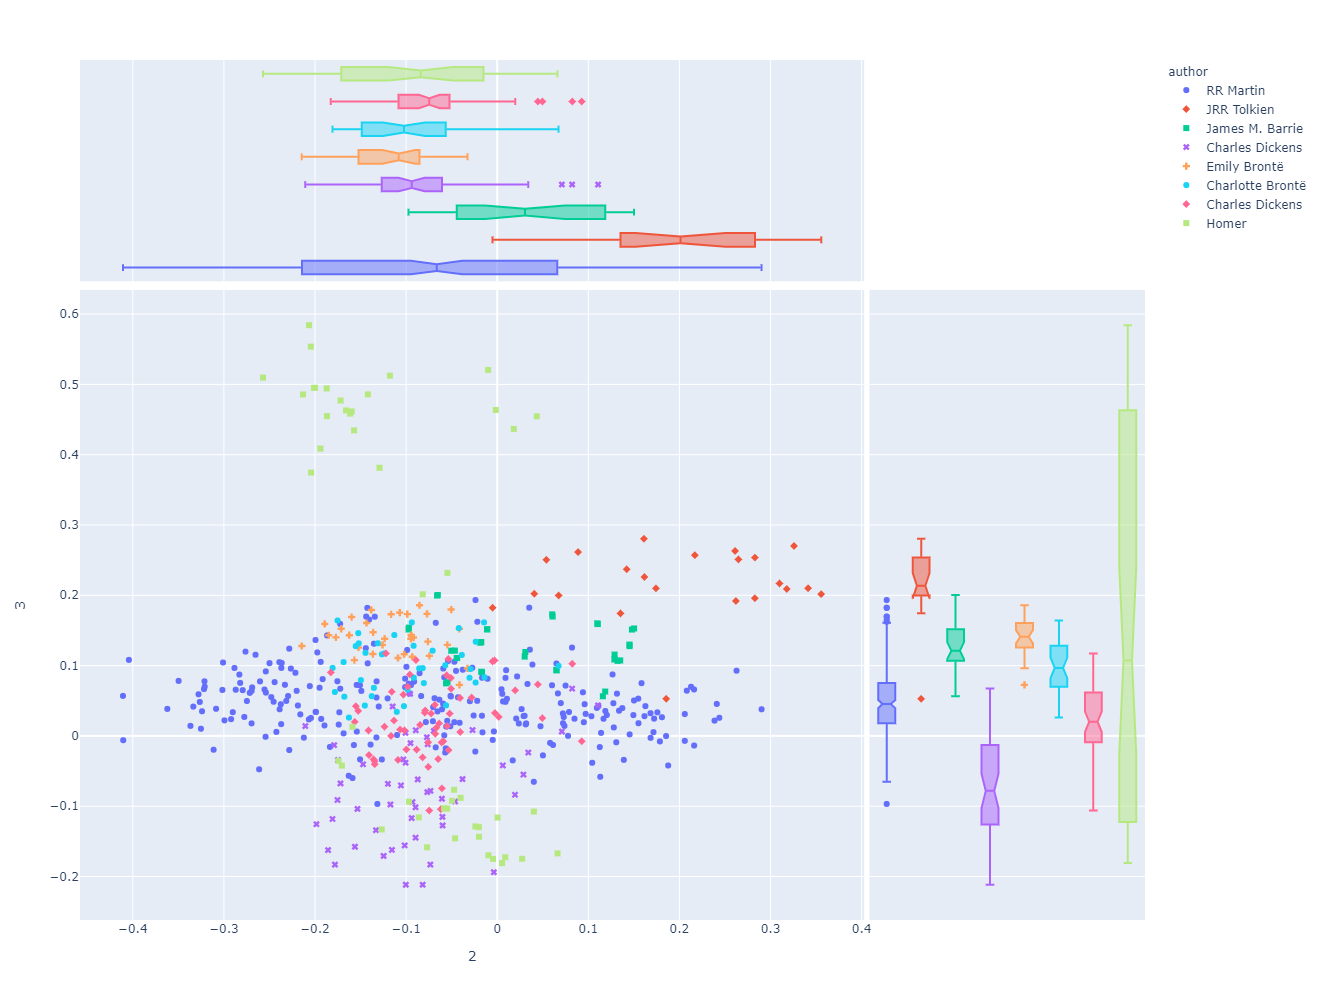

In [37]:
px.scatter(DOC, 2, 3, 
           color='author', symbol='author', 
           hover_name='author', 
           marginal_x='box', marginal_y='box', 
           height=1000)

In [38]:
LOADINGS.to_csv("data/LOADINGS.csv")
DCM.to_csv("data/DCM.csv")
COMPINF.to_csv("data/COMPINF.csv")